<a href="https://colab.research.google.com/github/jarvez31/Object_representation_model/blob/main/Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -q tensorflow-model-optimization
#!pip install unrar 
!pip install csaps
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data_fol = "/content/drive/MyDrive/sachin_deshmukh_proj/naya_data/"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


### Functions

In [ ]:

import matplotlib, math, random, shapely, csaps, scipy.interpolate, pickle, timeit, csv, scipy.io 
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from itertools import zip_longest
from scipy.spatial.distance import cdist
from shapely.geometry import LineString, LinearRing, box, Point, Polygon
from shapely.ops import nearest_points, unary_union
from numpy import matlib
from itertools import zip_longest
#from traj_func import new_circle, checkinside, speedpos, smax, myfrenet, hd, collect
import timeit

def new_circle(flag, obj, c):
    if obj == False:
        # creating the circle
        if flag == 1:
            r = 0.3
            p = Point(c)
            sq = p.buffer(r)

        # creating a plus
        if flag == 2: 
            sq = Polygon([(-0.5,-0.5), (-0.5, -2.0), (0.5, -2.0), (0.5, -0.5), (2.0, -0.5), (2.0, 0.5), (0.5, 0.5), (0.5, 2.0), (-0.5, 2.0), (-0.5, 0.5), (-2.0, 0.5), (-2.0, -0.5)])

        # creating a radial arm maze and multicompartment
        if flag == 3:
            #sq = Polygon([(-0.39, 0.88), (-0.88, 0.82), (-0.88, 0.22), (-0.31, 0.57), (-0.66,0), (-0.06,0), (0,0.49), (0.06, 0), (0.66, 0), (0.31, 0.57), (0.88, 0.22), (0.88, 0.82), (0.39, 0.88), (0.88, 0.94), (0.88, 1.54), (0.31, 1.19), (0.66, 1.76), (0.06, 1.76), (0, 1.27), (-0.06, 1.76), (-0.66, 1.76), (-0.31, 1.19), (-0.88, 1.54), (-0.88, 0.94)])
            sq = Polygon([(0, 0.0), (0, 0.24), (0.3, 0.24), (0.3, 0.25), (0, 0.25), (0,1), (0.95,1), (0.95,0.25), (0.7, 0.25), (0.7, 0.24), (0.95, 0.24), (1.3, 0.24), (1.3, 0.25), (1.05, 0.25), (1.05, 1), (1.95, 1), (1.95, 0.25), (1.7, 0.25), (1.7, 0.24), (1.95, 0.24), (2.3, 0.24), (2.3, 0.25), (2.05, 0.25), (2.05, 1), (2.95, 1), (2.95, 0.25), (2.7, 0.25), (2.7, 0.24), (3.3, 0.24), (3.3, 0.25),(3.05,0.25), (3.05,1),(4,1), (4,0.25), (3.7, 0.25), (3.7, 0.24), (4, 0.24),(4, 0), (0,0)])
        #creating a rectangular box
        if flag == 4:
            sq = box(0.30, 0.30, 0.70, 0.70)
        if flag == 5:
            sq = box(-1.0, -1.0, 1.0, 1.0)

    elif obj == True: # if there is an object in the environment
        # creating a circular object
        if flag == 1:
            r = 0.2
            p = Point(c)
            sq = p.buffer(r)

        if flag == 2:
            sq = Polygon(c)

        if flag == 3:
            print("hello")
            sq = box(c[0], c[1], c[2], c[3])
        
        if flag == 4:
            sq = box(-0.20, -0.20, 0.20, 0.20)

        if flag == 5:
            sq = box(0.30, 0.30, 0.70, 0.70)
        
        if flag == 6:
            sq = box(0.30, -0.70, 0.70, -0.30)  

        if flag == 7:
            sq = box(c[0], c[1], c[2], c[3])

    # seperating cords    
    k = list(sq.exterior.coords)
    xi = [m[0] for m in k ]
    yi = [m[1] for m in k ]

    #plotting both the boundaries
    plt.plot(xi, yi)
    return k, xi, yi



def collect(boxes):
    # creating a collection of given entities in the arena (objs + env)
    ll_o = [LinearRing(boxes[0])]
    
    if boxes[1]:
        ll_s = [LinearRing(j[0]) for j in boxes[1]]
        ll = ll_o + ll_s
    else:
        ll = ll_o

    return ll



def checkinside(x, ll, pos_far):
    # find the closest intersection point from current position in the arena 
    pos = x

    pp = unary_union(ll)
    line_cords = LineString([tuple(pos), tuple(pos_far)])

    temp = pp.intersection(line_cords)
    if temp.is_empty: 
        temp_x1 = pos_far[0]
        temp_y1 = pos_far[1]
    else:
        J = np.array(temp)
        if (np.ndim(J) == 1):
            temp_x1 = J[0]
            temp_y1 = J[1]
        else:
            K = np.matlib.repmat(x, len(J), 1)
            L = cdist(J, K)
            M = np.diag(L)
            ind = list(M).index(min(M))
            temp_x1 = J[ind][0]
            temp_y1 = J[ind][1]
    return temp_x1, temp_y1




def smax(q,beta): 
    # generating random probability to flip the direction
    sprob = 0
    q = np.array([1, 1])
    # beta = 0.9
    for i in q:
        sprob = sprob + np.exp(beta*i)
    
    Prob = np.exp(beta*q[0])/sprob
    if random.random() <= Prob :
        Act = 1
    else:
        Act = -1
    return Act



def speedpos(x, y, dt):
    # finding speed of given coords
    speed = []
    for i in range(1, len(x)):
        dist = np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2)
        #dist = np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2)/dt
        speed.append(dist)

    return speed



def hd(x2, y2):
    # calculating theta for given coords
    tgn = myfrenet(x2, y2) # tangent vectors at all the points
    ang = [] 
    p = tgn.shape
   
    # adjusting angle according to different quadrants
    for i in range(p[0]):
        temp = math.degrees(math.atan(tgn[i, 1]/tgn[i, 0]))
        if tgn[i, 0] >= 0:
            if tgn[i,1] >= 0:
                # quadrant 1
                ang.insert(i, temp)
            else:
                #quadrant 4
                ang.insert(i, (temp+360))
        else:
            if (tgn[i, 1] >= 0) or (tgn[i, 1] <= 0):
                # quadrant 2, 3
                ang.insert(i, (temp+180))
    return ang



def myfrenet(x1, y1):
    sz = x1.shape
    
    # calculate derivatives of the curve using spline method
    X = csaps.CubicSmoothingSpline(range(sz[0]), x1, smooth = 1.021)
    Y = csaps.CubicSmoothingSpline(range(sz[0]), y1, smooth = 1.021)
    p = np.asarray(range(sz[0]))
    mx = scipy.misc.derivative(X, p)
    my = scipy.misc.derivative(Y, p)
    A = [mx, my] # list of all derivative vectors at given points of curve
    
    # discard bad points
    j1 = np.sqrt(np.sum(np.multiply(A,A),axis=0))
    ind = np.nonzero(j1)
    data_x =[mx[i]for i in ind[0]]
    data_y =[my[i]for i in ind[0]]
    data = np.transpose(np.array([data_x, data_y])) # array with non-zero derivative values
    
    # Normalize Tangents
    T_1 = np.sqrt(np.sum(np.multiply(data,data),axis=1))
    T = np.divide(data,np.column_stack((T_1, T_1)))
    
    # finding derivatives at given trajectory inputs
    fx = scipy.interpolate.interp1d(ind[0], np.transpose(T), axis=1)
    T = np.transpose(fx(p))
    
    # Normalize all the tangent vectors
    Tang_1 = np.sqrt(np.sum(np.multiply(T,T),axis=1))
    Tang = np.divide(T,np.column_stack((Tang_1,Tang_1)))
    
    return Tang
  

def unitvec(pos_corr):
    temp1 = np.subtract(pos_corr[1:, :], pos_corr[:-1, :])
    temp2 = np.sqrt((temp1*temp1).sum(axis=1))
    temp3 = temp1 / temp2.reshape(temp1.shape[0],1)
    return temp3

def abs_theta(pos2):
    Hd_rep = unitvec(pos2)
    # EXTRACTING ABSOLUTE THETA
    ground_theta = []
    for i in range(len(pos)-1):
      temp1 = np.rad2deg(np.arctan(abs(pos2[i, 1]/pos2[i, 0])))
  
      if (Hd_rep[i,0]>0 and Hd_rep[i,1]>0):
        ground_theta.append(temp1)
      if (Hd_rep[i,0]<0 and Hd_rep[i,1]>0):
        ground_theta.append(180 - temp1)
      if (Hd_rep[i,0]<0 and Hd_rep[i,1]<0):
        ground_theta.append(180 + temp1)
      if (Hd_rep[i,0]>0 and Hd_rep[i,1]<0):
        ground_theta.append(360 - temp1)

    ground_theta = np.asarray(ground_theta)
    # ground_theta = ground_theta/(2*mt.pi)

    return ground_theta

def obj_union(obj_list):
    ll = [LinearRing(j) for j in obj_list[1]]
    pp = unary_union(ll)
    return pp



### Trajectory

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars


5000
10000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: overflow encountered in double_scalars


15000
20000
Time:  5.600721582000915


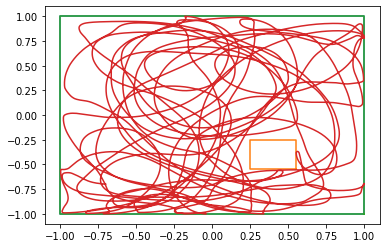

In [ ]:
#%%
#import ctypes
#ctypes.windll.LoadLibrary(r"c:\tools\depends\depends.dll")

#random.seed(1)
#np.random.seed(1)
#%% 
# -------------------------------------------------Initialization------------------------------------------------------
start = timeit.default_timer()

# Trajectory starting points
x = -0.7 #-0.5
y = -0.7 #0.5
# designing the experiment area
outer_box, box_x, box_y = new_circle(5, False, (0,0))
objs = []

# centres for multiple objects (comment this part if there is no object)
flag = 7
hf_sz = 0.15
obj_c = [(0.4, -0.4)]#, (0.4, 0.4)]
obj_ver = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c]#, [(0,0.5), (-0.3, 1.0), (0, 1.5), (0.3, 1.0), (0, 0.5)], (-1.5,-0.5,-1,0)]
for i in obj_ver:
    objs.append(new_circle(flag, True, i)) 
    # print(flag)
    # flag += 1


# geometrical collection of the entire arena (env + object)
boxes = [outer_box, objs]
# print(objs)

#boxes = [outer_box]
ll = collect(boxes)


# required variables
r1 = 1
r2 = 1
t = random.randint(0, 360)
theta = t/(2*math.pi)
T = 20000
ro = 0.05
dt = 0.01
xhist = np.array([])
yhist = np.array([])
a = 0
q = np.array([1, 0.9])
pm = 1
dist = np.zeros([4,1])
curv = np.zeros([1,T+2])
c_dist = 0

#%%
# ------------------------Trajectory_Generation---------------------------
for i in range(1, T+1):
    
    if (i%5000==0):
        print(i)
    # direction flipping
    adot = -a + pm * smax(q,1/(1*r1))
    if (i % 1000) == 0:
        pm = -1*pm
    
    # position of agent and update
    xhist = np.append(xhist, x,)
    yhist = np.append(yhist, y,)
    xdot = r1 * np.cos(theta)
    ydot = r2 * np.sin(theta)

    # current and far position
    pos = np.array([x, y])
    pos_far = np.array([(x + 1000 * xdot), (y + 1000 * ydot)])
  
    # when far position isn't far enough
    if (i>2): 
        if (r1 == c_dist):
            pos_far = np.array([(x + 10000 * xdot), (y + 10000 * ydot)])

    # step updation rule
    temp_x1c, temp_y1c = checkinside(pos, ll, pos_far) # closest intersection point
    c_dist = np.linalg.norm(np.array([(x - temp_x1c), (y - temp_y1c)])) # dist from intersection points

    r1 = c_dist
    r2 = c_dist
    #print(i,xdot, x)
    # variable update
    tdot = a/ro
    x = x + dt * xdot
    y = y + dt * ydot 
    theta = theta + 1 * dt * tdot
    a = a + 1 * dt * adot

    if (i > 23):
        if (xhist[i - 1] == xhist[i - 20]):
            break

# time taken to run the code
stop = timeit.default_timer()
print('Time: ', stop - start)
#%%
# ---------------------------plotting_the_trajectory------------------------
pos = np.column_stack((xhist,yhist))
plt.plot(box_x, box_y)
plt.plot(xhist, yhist)
plt.show()


#%%
# --------------------------calculating_variables----------------
speed = speedpos(xhist, yhist, dt)
# theta_real_deg = hd(xhist, yhist)
pos = np.column_stack((xhist, yhist))
theta_real_deg = abs_theta(pos)
theta_real_deg = np.append(theta_real_deg, theta_real_deg[-1]) 
# plt.plot(xhist,yhist)
# plt.show()


#%%
#saving variables in pickle file
d = {'x':list(xhist), 'y':list(yhist), 'speed':list(speed), 'theta': list(theta_real_deg), 'env': outer_box, 'obj': objs}
with open(data_fol + 'traj_obj(sh4)_20k.pk1', 'wb') as f:
    pickle.dump(d, f)

#saving variable in csv file
csvfile = data_fol + "traj_obj(sh4)_20k.csv" 
with open(csvfile, "w", newline='') as f:
    w = csv.writer(f)
    # w.writerow(["xhist", "yhist", "theta", "env", "obj"])
    for a, b, c in zip_longest(xhist, yhist, theta_real_deg):
        w.writerow([a, b, c])           

# extra
    # (importing mat file)
        # mat = scipy.io.loadmat('filename')
        # locals().update(mat) --------------makes all keys variables if it is a dictionary, which it always is-------------------

    # (importing from pickle file)
        # with open('filename', 'rb') as l:
            # j = pickle.dump(l)


# %%

###Meshgrid datapoints

POLYGON ((0.7 0.3, 0.7 0.7, 0.3 0.7, 0.3 0.3, 0.7 0.3))
[[-1.00000000e+00 -1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00  1.20000000e+01  9.78147601e-01
   2.07911691e-01]
 [-1.00000000e+00 -1.00000000e+00  2.40000000e+01  9.13545458e-01
   4.06736643e-01]
 ...
 [ 1.00000000e+00  1.00000000e+00  3.24000000e+02  8.09016994e-01
  -5.87785252e-01]
 [ 1.00000000e+00  1.00000000e+00  3.36000000e+02  9.13545458e-01
  -4.06736643e-01]
 [ 1.00000000e+00  1.00000000e+00  3.48000000e+02  9.78147601e-01
  -2.07911691e-01]]
(25920, 5)


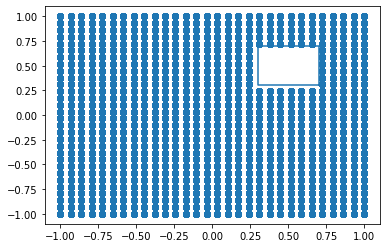

In [ ]:
theta = []
position = []
theta = []
gt = []
pos_temp = []
obj1, _, _= new_circle(4, False, (0,0))
# obj2, _, _= new_circle(1, False, (0,0.5))
# obj3, _, _= new_circle(5, False, (0,0))
# objs = [obj1,obj2]
obj1 = Polygon(obj1)
# obj2 = Polygon(obj2)
# obj3 = Polygon(obj3)
print(obj1)
#pp = obj_union(objs)
for i in np.linspace(-1,1,30, endpoint=True):
  
  for j in np.linspace(-1,1,30, endpoint=True):
    
    
    for k in np.linspace(0,360,30, endpoint=False):
      p = Point(i,j)
      if(not obj1.contains(p)):# and (not obj2.contains(p)) and (not obj3.contains(p))):
        pos_temp.append([i,j])
        theta.append(k)
cos_theta = np.cos(np.deg2rad(theta))
sin_theta = np.sin(np.deg2rad(theta))
Hd = np.column_stack((theta, cos_theta, sin_theta))
gt = np.column_stack((pos_temp, Hd))
#gt.append(gt_temp)
  #position.append(pos)
print(gt)
print(gt.shape)
#plt.plot(gt[:,0])
#plt.show()
#plt.plot(gt[:,1])
#plt.show()
#plt.plot(gt[0:300,2])
#plt.show()
#plt.plot(gt[0:30,3])
#plt.show()
#print(gt[0:30,2])
#plt.plot(gt[0:30,4])
pos_temp = np.asarray(pos_temp)
plt.scatter(pos_temp[:,0], pos_temp[:,1])
plt.show()
d = {'x':list(np.asarray(pos_temp)[:,0]), 'y':list(np.asarray(pos_temp)[:,1]), 'theta': list(theta)}
with open(data_fol + 'meshgrid_obj(sh)_30.pk1', 'wb') as f:
    pickle.dump(d, f)

csvfile = data_fol + "meshgrid_obj(sh)_30.csv" 
with open(csvfile, "w", newline='') as f:
    w = csv.writer(f)
    # w.writerow(["xhist", "yhist", "theta"])
    for a, b, c in zip_longest(np.asarray(pos_temp)[:,0], np.asarray(pos_temp)[:,1], theta):
        w.writerow([a, b, c])  

### Saving Data for Unity

In [ ]:
traj = data_fol + traj1

with open(traj, "rb") as f:
    d = pickle.load(f)
    f.close()
locals().update(d)

In [ ]:
from itertools import zip_longest
csvfile = data_fol + "meshgrid_obj_20.csv" 
with open(csvfile, "w", newline='') as f:
    w = csv.writer(f)
    w.writerow(["x", "y", "theta"])
    for a, b, c in zip_longest(file[:,0], file[:,1], theta_new_deg):
        w.writerow([a, b, c])

d = {'x':list(file[:,0]), 'y':list(file[:,1]), 'theta': list(theta_new_deg), 'env': list(env), 'obj': list(obj)}
with open(data_fol + 'meshgrid_obj_20.pk1', 'wb') as f:
    pickle.dump(d, f)

NameError: ignored

In [ ]:
import pickle
name = data_fol + "traj_obj(sh2)_20k.pk1"
with open(name, 'rb') as traj:
  trj = pickle.load(traj)
  traj.close()
locals().update(trj)

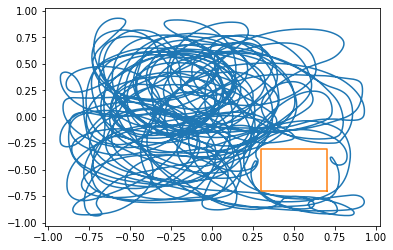

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.plot(obj[0][1], obj[0][2])
plt.show()

In [ ]:
print(obj[0][1])

[0.7, 0.7, 0.3, 0.3, 0.7]
